# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [1]:
import matplotlib.pyplot as plt
import cv2  # нужно поставить себе cv2 через conda install opencv
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from skimage.metrics import structural_similarity as ssim
from sklearn.neighbors import NearestCentroid
import numpy as np


def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image)  # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

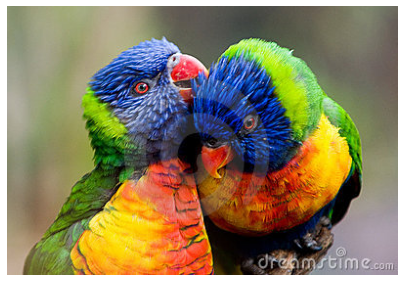

In [3]:
img = cv2.imread('birds.jpg')  # считать картинку
draw_picture(img)  # нарисовать картинку

In [5]:
print(img.shape)  # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [6]:
new_img = img.reshape(img.shape[0] * img.shape[1], 3)

In [7]:
clusters_count = [2, 3, 10, 20]

Посмотрим на K-means

SSIM: 0.5333943885059159
Количество кластеров: 2


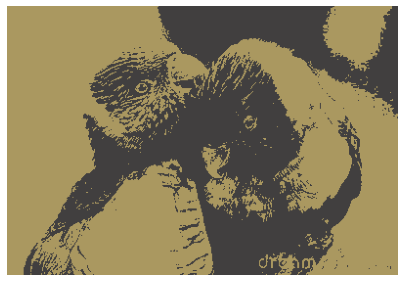

SSIM: 0.5634994634289958
Количество кластеров: 3


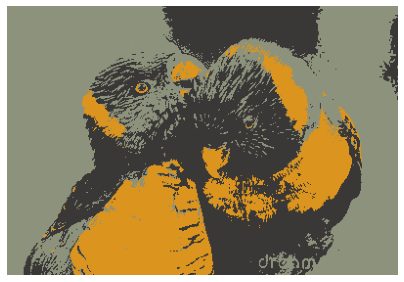

SSIM: 0.6789120278107573
Количество кластеров: 10


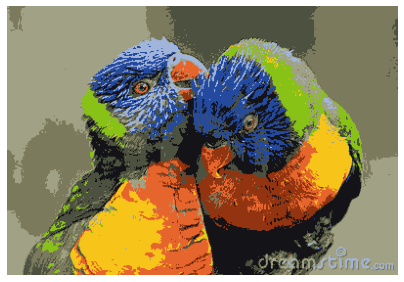

SSIM: 0.7607445400917786
Количество кластеров: 20


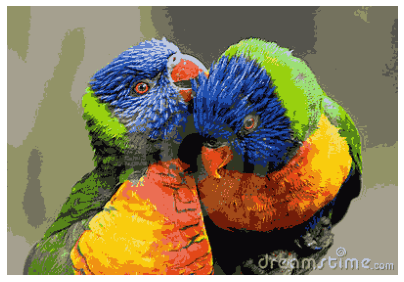

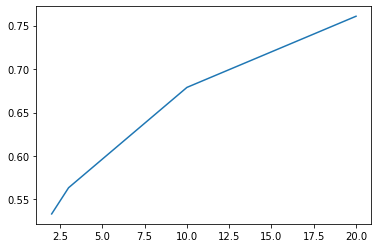

In [61]:
list_ssim = []
for clusters in clusters_count:
    kmeans = KMeans(n_clusters=clusters, random_state=42)
    kmeans.fit(new_img)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    predict_img = centers[labels].reshape(275, 400, 3).astype('uint8')
    ssim_ = ssim(img, predict_img, channel_axis=2)
    list_ssim.append(ssim_)
    print(f'SSIM: {ssim_}\nКоличество кластеров: {clusters}')
    draw_picture(predict_img)
plt.plot(clusters_count, list_ssim)

Лучший результат, при 20 кластерах

Посмотрим на DBSCAN (параметры подберем, простым перебором)

In [73]:
best_eps = None
best_sample = None
best_ssim = 0
eps_list = np.arange(1, 30, 3)
samples_list = np.arange(5, 25, 5)

In [74]:
for eps in eps_list:
    for sample in samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=sample)
        dbscan.fit(new_img)
        centers = dbscan.components_
        labels = dbscan.labels_
        predict_img = centers[labels].reshape(275, 400, 3).astype('uint8')
        ssim_ = ssim(img, predict_img, channel_axis=2)
        if ssim_ > best_ssim:
            best_ssim = ssim_
            best_eps = eps
            best_sample = sample
print(f'SSIM: {best_ssim}\neps:{best_eps}\nsamples:{best_sample}')

SSIM: 0.4139846867174635
eps:7
samples:20


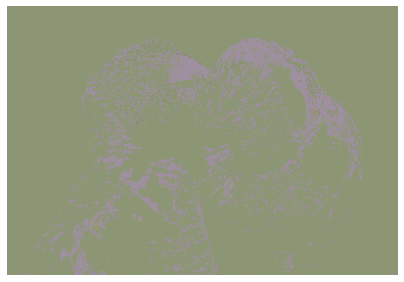

In [80]:
dbscan = DBSCAN(eps=7, min_samples=20)
dbscan.fit(new_img)
centers = dbscan.components_
labels = dbscan.labels_
predict_img = centers[labels].reshape(275, 400, 3).astype('uint8')
draw_picture(predict_img)

Как видим, все плохо

Посмотрим на агломеративную кластеризацию

In [20]:
# понизим разрешение (120,120,3)
agg = AgglomerativeClustering(n_clusters=2, compute_distances=True).fit(new_img)

MemoryError: Unable to allocate 45.1 GiB for an array with shape (6049945000,) and data type float64

In [36]:
img_resized = cv2.resize(img, dsize=(120, 120), interpolation=cv2.INTER_AREA)
new_img_resized = img_resized.reshape(img_resized.shape[0] * img_resized.shape[1], 3)

SSIM: 0.43745253886883795


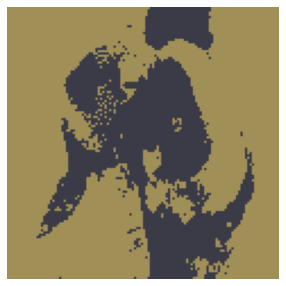

SSIM: 0.4614542998403146


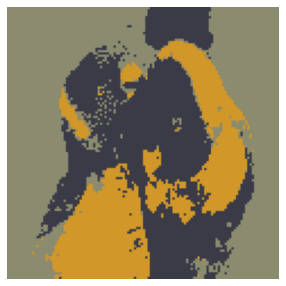

SSIM: 0.6506067739705651


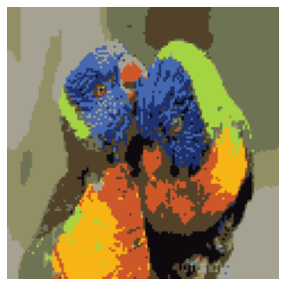

SSIM: 0.7448899681013722


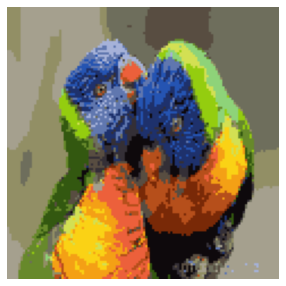

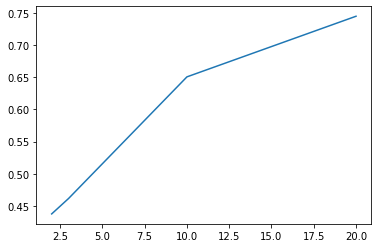

In [37]:
list_ssim = []
for clusters in clusters_count:
    agg = AgglomerativeClustering(n_clusters=clusters)
    predict = agg.fit_predict(new_img_resized)
    clf = NearestCentroid().fit(new_img_resized, predict)
    centers = clf.centroids_
    labels = agg.labels_
    predict_img = centers[labels].reshape(120, 120, 3).astype('uint8')
    ssim_ = ssim(img_resized, predict_img, channel_axis=2)
    list_ssim.append(ssim_)
    print(f'SSIM: {ssim_}')
    draw_picture(predict_img)
plt.plot(clusters_count, list_ssim)

При 20 кластерах агломеративная кластеризация, показала лучший результат

Запустим Kmeans при n_cluster = 30

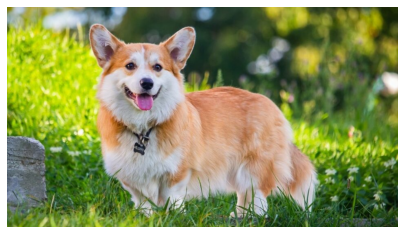

In [38]:
img_korgi = cv2.imread('korgi.jpg')
draw_picture(img_korgi)

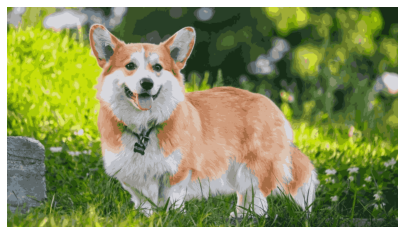

In [53]:
new_img_korgi = img_korgi.reshape(img_korgi.shape[0] * img_korgi.shape[1], 3)
kmeans = KMeans(n_clusters=30)
kmeans.fit(new_img_korgi)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
predict_img = centers[labels].reshape(img_korgi.shape[0], img_korgi.shape[1], 3).astype('uint8')
draw_picture(predict_img)

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [54]:
import warnings

warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [55]:
from sklearn.model_selection import train_test_split

X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [57]:
X.shape  # 2370 лиц, каждый из них представляется вектором размера 11750

(2303, 11750)

In [58]:
y.shape

(2303,)

In [59]:
names[8]  # в y лежат номера, а names переводит номер в имя

'George W Bush'

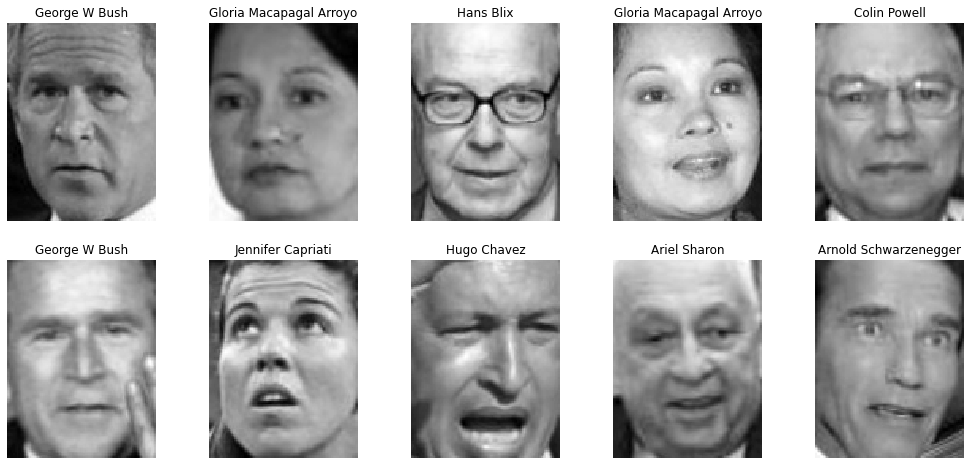

In [60]:
import matplotlib.pyplot as plt


def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')


def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')


plot_grid(range(10), nrows=2, ncols=5)  # первые 10 лиц

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA

Используем PCA, так как у нас слишком много компонент, так как TSNE уменьшает лишь до 3 (А у нас их 11750)

In [65]:
components_count = np.arange(10, 410, 10)
logreg_acc = []
tree_acc = []

for components in components_count:
    pca = PCA(n_components=components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    logreg = LogisticRegression(random_state=42).fit(X_train_pca, y_train)
    tree = DecisionTreeClassifier(random_state=42, max_depth=7).fit(X_train_pca, y_train)

    logred_predict = logreg.predict(X_test_pca)
    tree_predict = tree.predict(X_test_pca)

    logreg_acc.append(accuracy_score(y_test, logred_predict))
    tree_acc.append(accuracy_score(y_test, tree_predict))


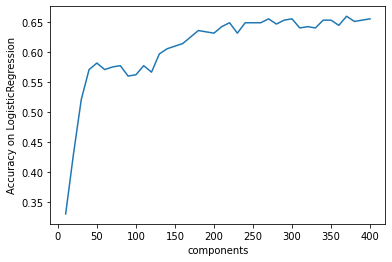

In [71]:
plt.plot(components_count, logreg_acc)
plt.xlabel('components')
plt.ylabel('Accuracy on LogisticRegression')
plt.show()

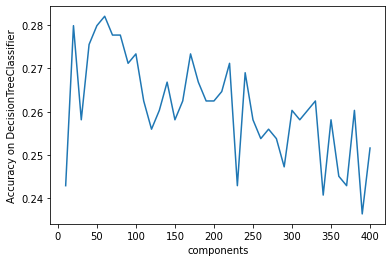

In [72]:
plt.plot(components_count, tree_acc)
plt.xlabel('components')
plt.ylabel('Accuracy on DecisionTreeClassifier')
plt.show()

In [73]:
best_acc = 0
best_components = 0
for components in range(50, 250, 10):
    pca = PCA(n_components=components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    logreg = LogisticRegression(random_state=42).fit(X_train_pca, y_train)
    logreg_predict = logreg.predict(X_test_pca)
    logreg_acc = accuracy_score(y_test, logreg_predict)

    if best_acc < logreg_acc:
        best_components = components
        best_acc = logreg_acc
print(f'Best components count:{best_components}\nBest accuracy{best_acc}')

Best components count:220
Best accuracy0.648590021691974


Сравним с константным предсказанием

In [76]:
pca = PCA(n_components=best_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
dummy = DummyClassifier().fit(X_train_pca, y_train)
dummy_predict = dummy.predict(X_test_pca)
print(f'Accuracy on dummy: {accuracy_score(y_test, dummy_predict)}')

Accuracy on dummy: 0.19739696312364424


LogisticRegression намного лучше, теперь посмотрим, где мы ошиблись

In [77]:
pca = PCA(n_components=best_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
logreg = LogisticRegression(random_state=42).fit(X_train_pca, y_train)
logreg_predict = logreg.predict(X_test_pca)

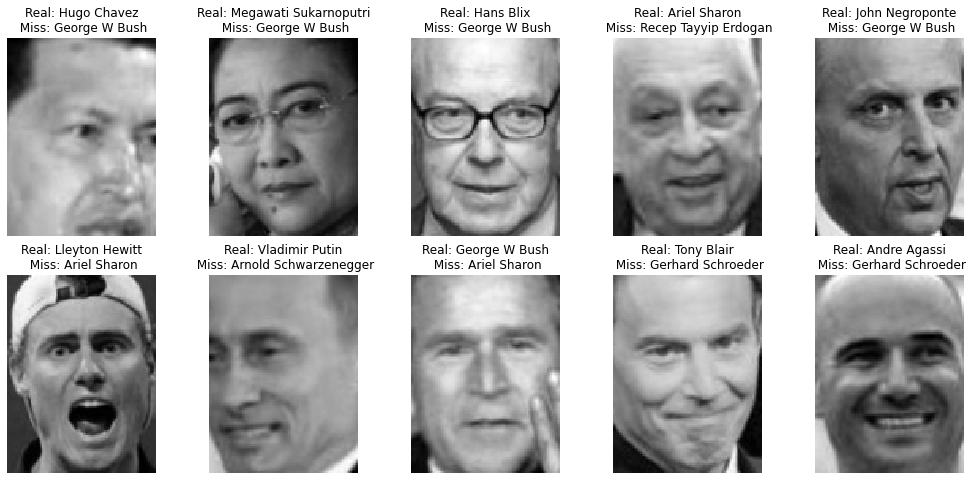

In [96]:
y_test_miss = y_test[y_test != logreg_predict]
y_pred_name = logreg_predict[y_test != logreg_predict]

def plot_image_new(image_id,miss_id):
    # функция рисует изображение номер image_id и real name и miss name
    plt.title(f'Real: {names[y[image_id]]}\n Miss: {names[y[miss_id]]}')
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')

fig = plt.gcf()
fig.set_size_inches(17.5, 8)

for index, example_id in enumerate(range(10)):
    plt.subplot(2, 5, index + 1)
    real_id = y_test_miss[example_id]
    miss_id = y_pred_name[example_id]
    plot_image_new(real_id,miss_id)
    plt.axis('off')

Визуализируем данные, для этого воспользуемся TSNE (он лучше преобразует в 2D и 3D)

In [100]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

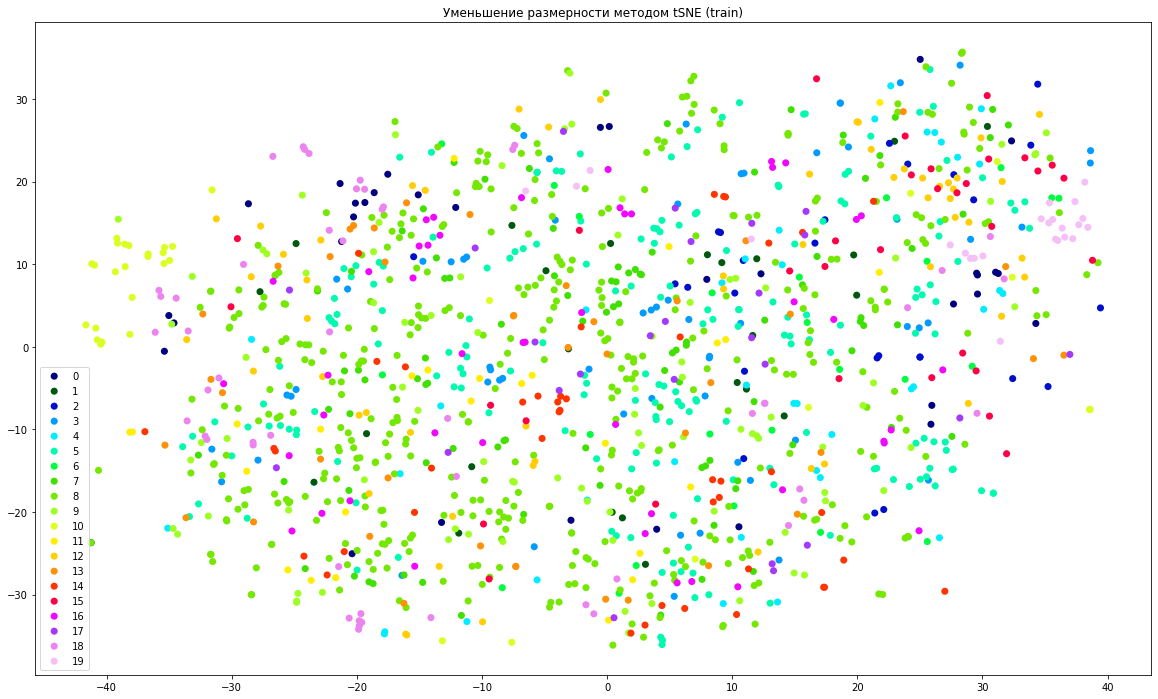

In [108]:
X_train_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_train)
plt.figure(figsize=(20, 12))
for d in range(20):
    norm = Normalize(vmin=0, vmax=20)
    color = plt.cm.gist_ncar(norm(d))
    plt.scatter(X_train_tsne[:, 0][y_train == d],
                X_train_tsne[:, 1][y_train == d],
                c=[color] * len(X_train_tsne[:, 0][y_train == d]), label=d, edgecolor='none', s=50)
plt.title('Уменьшение размерности методом tSNE (train)')
plt.legend()